In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

# Deep Lyrics Generator - ULMFiT

## Set up instructions

### Create VM Instance

- Go to cloud.google.com, and create a new VM instance
- Disk size: 100GB or more
- CPUs + Memory: 2vCPUs, 7.5 GB Memory
- GPU: K80 (cheaper, less power) or P100 (2.5x more expensive, more power)
- Enable http, https traffic
- Boot: Deep learning pytorch instance

### Network configuration

In Google cloud platform:

- Go to Networking -> VPC Network, External IP addresses
- Select your VM instance and change the external address type from Ephemeral to Static
- Go to Networking -> VPC Network, Firewall Rules
- Add a new Rule, called Jupyter, ip ranges 0.0.0.0/0, protocols and ports tcp:8888, apply to all targets

### VM + Jupyter Setup

- SSH to VM
- Enlist into Github repo
- Run src/setup.sh
- Run jupyter notebook
- Open a google cloud shell
- Run gcloud init and answer the questions
- To set up a tunnel and run jupyter locally, run ```gcloud compute --project "<your project>" ssh --zone "<your zone>" "<your instance name>" -- -L 8888:localhost:8888```
- Open jupyter notebook in your local computer and have fun

### Notebook first run
Here are some steps to run the first time you use the notebook.

#### Tokens
To create the model's tokens with the correct train-test split, run ```src/data_collection/lm_data_lyrics.py -o path/to/save```. 
We recommend saving in data/models/{MODEL_NAME}. Alternatively, run the magic command below and replace the model name.

In [2]:
%run ../src/data_collection/lm_data_lyrics.py -o ../data/models/3.1-ULMFiT-108k

Numericalizing train.
Numericalizing valid.


## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [2]:
model_name = '3.1-ULMFiT-108k'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

In [3]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

print(data_lm.train_ds.vocab_size)

10002


## Model setup

In [63]:
GPU = True

In [64]:
learn = RNNLearner.language_model(data_lm,
                                  pretrained_model=URLs.IMDB,
                                  drop_mult=0.5)

save_callback = SaveModel(learn, model_name='ULMFiT_3.0-108k')

In [65]:
DOWNLOAD_MODEL_WEIGHTS = True
weights_url = 'https://storage.googleapis.com/w210-capstone/models/ULMFiT_3.0-108k_best.pth'

if DOWNLOAD_MODEL_WEIGHTS:
    Path(MODEL_PATH/'models').mkdir(exist_ok=True)
    download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=True)

In [66]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [67]:
if not GPU:
    learn.cpu_load(f'{model_name}_best')
else:
    learn.load(f'{model_name}_best')

## Training

In [68]:
TRAIN = True

In [69]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [70]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [71]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 12:31
epoch  train loss  valid loss  accuracy
0      2.981173    2.926813    0.442851  (12:31)



In [73]:
if TRAIN:
    learn.unfreeze()
    learn.fit(10, 1e-3, callbacks=[save_callback])

Total time: 2:05:22
epoch  train loss  valid loss  accuracy
0      2.908666    2.869007    0.449923  (12:33)
1      2.869597    2.843347    0.453256  (12:33)
2      2.814083    2.823984    0.456066  (12:33)
3      2.754369    2.810501    0.458073  (12:27)
4      2.739022    2.803386    0.459207  (12:34)
5      2.697838    2.794896    0.460672  (12:36)
6      2.677279    2.790182    0.461662  (12:34)
7      2.680177    2.786385    0.461968  (12:29)
8      2.641148    2.783062    0.463103  (12:28)
9      2.670224    2.780857    0.462928  (12:30)



In [74]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.7808568


#### Learning Loss

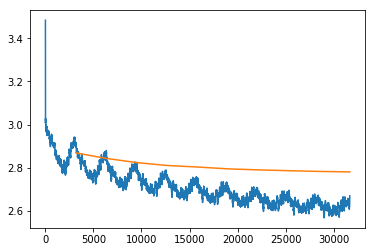

In [75]:
if TRAIN:
    learn.recorder.plot_losses()

## Model Load

## Text Generation

In [76]:
def generate_step(model, context, context_length):

    model.reset()
    model.eval()
    
    # forward pass the "context" into the model
    result, *_ = model(context[-context_length:])
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def print_words(sequence):
    for i in range(len(sequence[0])):
        
        step = sequence[0][i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            continue
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20):
    """Generates text with a given learner and prints string to console.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit

    Returns
    -------
    None : NoneType
        Doesn't return anything, prints string to console
    """
        
    model = learner.model
    
    if isinstance(seed_text, str):
        seed_text = seed_text.split(' ')
    
    if GPU:
        context = LongTensor(data_lm.train_ds.vocab.numericalize(seed_text)).view(-1,1).cuda()
    else:
        context = LongTensor(data_lm.train_ds.vocab.numericalize(seed_text)).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = 5
    
    # Reset model's hidden state
    # We don't want to carry over old contexts
    model.reset()
    model.eval()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the score is the multiplied probabilities of each word
    sequences = [[context, 1.0]]
    
    # Loop over max number of words
    for _ in range(max_len):
        
        print ('Generating word: ', _, '/', max_len)
        candidates = list()
        
        # For each top sequence, generate the next word, and pick #beam_width candidates
        for i in range(len(sequences)):
            
            seq, score = sequences[i]

            # Obtain probabilities for next word
            probabilities = generate_step(model, seq, context_length)
            
            # Multinomial draw of size beam_width. Greedy approach here would be to take top 5 probabilities.
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = sorted(range(len(multinom_draw)), key=lambda u: multinom_draw[u])[-beam_width:]

            # Add each of the candidate sequence+word to the candidate list
            for j in range(len(top_probabilities)):

                idx = top_probabilities[j]

                if GPU:
                    token_index = LongTensor([idx]).view(-1, 1).cuda()
                else:
                    token_index = LongTensor([idx]).view(-1, 1).cpu()

                new_context = torch.cat((seq.clone(), token_index.clone())) 

                # To have a regular multinomial, just make beam_width = 1 and change the line below for:
                # candidate = [new_context, (probabilities[idx])]
                candidate = [new_context, (score *probabilities[idx])]
                candidates.append(candidate)

        # Once we have the candidate words for each top sequence, do a multinomial draw based off the score to pick the top
        # Greedy version would be to pick top N scored sequences
        probs = [candidate[1] for candidate in candidates]
        multinom_draw = np.random.multinomial(beam_width , probs)
        top = sorted(range(len(multinom_draw)), key=lambda u: multinom_draw[u])[-beam_width:]
        
        top_candidates = list()
        for r in range(len(top)):
            top_candidates.append(candidates[top[r]])

        sequences = top_candidates
        
#         for seq in sequences:
#             print_words(seq)
#             print('\n')
        
        
    print_words(sequences[0])


In [85]:
generate_text(learn, GPU=GPU, seed_text='xbos xbol [verse-1] xeol xbol', max_len=100, context_length=50)

Generating word:  0 / 100
Generating word:  1 / 100
Generating word:  2 / 100
Generating word:  3 / 100
Generating word:  4 / 100
Generating word:  5 / 100
Generating word:  6 / 100
Generating word:  7 / 100
Generating word:  8 / 100
Generating word:  9 / 100
Generating word:  10 / 100
Generating word:  11 / 100
Generating word:  12 / 100
Generating word:  13 / 100
Generating word:  14 / 100
Generating word:  15 / 100
Generating word:  16 / 100
Generating word:  17 / 100
Generating word:  18 / 100
Generating word:  19 / 100
Generating word:  20 / 100
Generating word:  21 / 100
Generating word:  22 / 100
Generating word:  23 / 100
Generating word:  24 / 100
Generating word:  25 / 100
Generating word:  26 / 100
Generating word:  27 / 100
Generating word:  28 / 100
Generating word:  29 / 100
Generating word:  30 / 100
Generating word:  31 / 100
Generating word:  32 / 100
Generating word:  33 / 100
Generating word:  34 / 100
Generating word:  35 / 100
Generating word:  36 / 100
Generating 